In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report,
                           confusion_matrix,
                           roc_auc_score,
                           precision_recall_curve,
                           auc)
from xgboost import XGBClassifier, plot_importance
import joblib
import shap




In [2]:
# Set display and style options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


In [3]:
# Load dataset
data = pd.read_csv("/content/bankloans.csv")


In [4]:
# Display basic info
print("=== Dataset Overview ===")
print(f"Shape: {data.shape}")
print("\nFirst 5 Rows:")
display(data.head())


=== Dataset Overview ===
Shape: (1150, 9)

First 5 Rows:


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [5]:
# Check target distribution
print("\n=== Target Variable Analysis ===")
print("'default' value counts:")
print(data['default'].value_counts(normalize=True))


=== Target Variable Analysis ===
'default' value counts:
default
0.0    0.738571
1.0    0.261429
Name: proportion, dtype: float64


In [6]:
# Convert target to binary if needed
if data['default'].dtype == 'object':
    data['default'] = df['default'].map({'no': 0, 'yes': 1})

# Separate features and target
X = data.drop('default', axis=1)
y = data['default']


In [7]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("\n=== Feature Types ===")
print("Numeric Features:", numeric_features.tolist())
print("Categorical Features:", categorical_features.tolist())



=== Feature Types ===
Numeric Features: ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']
Categorical Features: []


In [8]:
# Create new features
X['debt_ratio'] = X['debtinc'] / 100  # Convert percentage to ratio
X['total_debt'] = X['creddebt'] + X['othdebt']
X['savings_rate'] = (X['income'] - X['total_debt']) / X['income']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [9]:

df = pd.read_csv('/content/bankloans.csv')

# Check target column
if 'default' not in df.columns:
    raise ValueError("Target column 'default' not found in the dataset.")

# Convert target to binary if needed
if df['default'].dtype == 'object':
    df['default'] = df['default'].map({'no':0, 'yes':1})
# Handle Missing Targets
print("Original missing values:", df['default'].isna().sum())
df = df.dropna(subset=['default'])
print("Remaining missing values:", df['default'].isna().sum())
X = df.drop('default', axis=1)
y = df['default']

# Now your train_test_split will work
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Original missing values: 450
Remaining missing values: 0


In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

print("\n=== Class Distribution ===")
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))



=== Class Distribution ===
Before SMOTE: [414 146]
After SMOTE: [414 414]


In [11]:
 # Model Training (XGBoost)
model = XGBClassifier(
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    random_state=42,
    eval_metric='aucpr'
)

model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Model Evaluation
X_test_processed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

print("\n=== Model Performance ===")
print(classification_report(y_test, y_pred))


=== Model Performance ===
              precision    recall  f1-score   support

         0.0       0.89      0.63      0.74       103
         1.0       0.43      0.78      0.56        37

    accuracy                           0.67       140
   macro avg       0.66      0.71      0.65       140
weighted avg       0.77      0.67      0.69       140



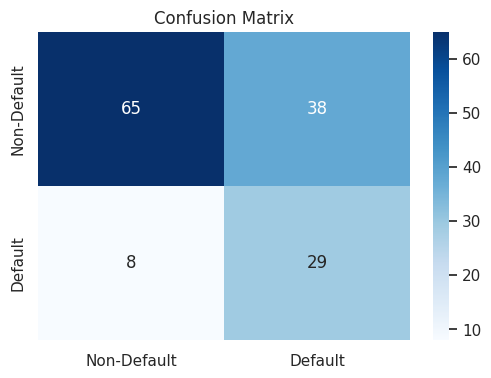

In [13]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix')
plt.show()

In [14]:
# ROC and PR curves
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")


ROC AUC: 0.797
PR AUC: 0.632


<Figure size 1000x600 with 0 Axes>

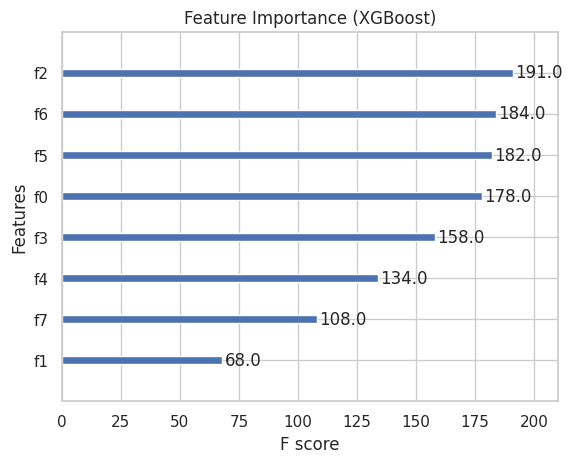

In [15]:
# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(model)
plt.title('Feature Importance (XGBoost)')
plt.show()

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:217: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


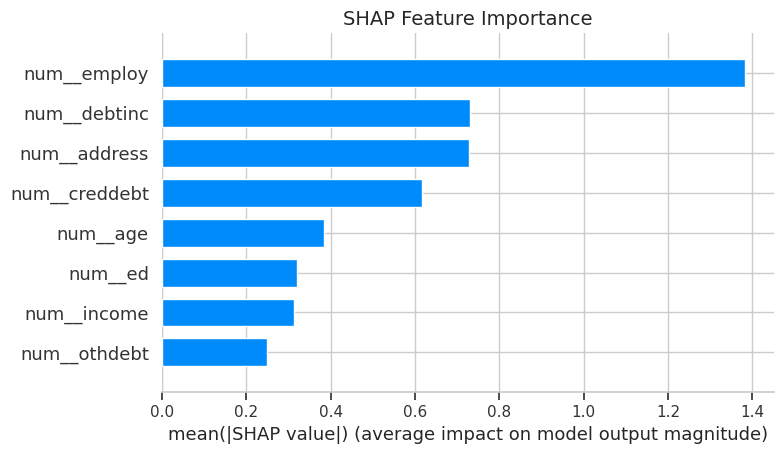

In [17]:
# SHAP Analysis
try:
    # Initialize explainer with interventional approach
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="interventional",  # Changed from default
        data=None  # Using no background (faster and more reliable)
    )

    # Calculate SHAP values - use a reasonable sample size
    sample_size = min(100, len(X_test_processed))  # Use 100 or all if fewer
    shap_values = explainer.shap_values(X_test_processed[:sample_size])

    # Get feature names from preprocessor
    feature_names = preprocessor.get_feature_names_out()

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Handle binary/multi-class cases
    if isinstance(shap_values, list):  # Multi-class
        shap.summary_plot(shap_values[1],  # Show class 1 (positive class)
                         X_test_processed[:sample_size],
                         feature_names=feature_names,
                         plot_type='bar',
                         show=False)
    else:  # Binary
        shap.summary_plot(shap_values,
                         X_test_processed[:sample_size],
                         feature_names=feature_names,
                         plot_type='bar',
                         show=False)

    plt.title("SHAP Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"SHAP Error: {str(e)}")
    print("\nDebug Info:")
    print("Model score:", model.score(X_test_processed, y_test))
    print("X_test_processed shape:", X_test_processed.shape)
    if 'feature_names' in locals():
        print("Feature names sample:", feature_names[:5])
    else:
        print("Feature names not available - check preprocessor")

In [18]:
# 10. Save Model
# ======================
joblib.dump(model, 'credit_risk_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("\n=== Model Saved ===")
print("credit_risk_model.pkl and preprocessor.pkl created")



=== Model Saved ===
credit_risk_model.pkl and preprocessor.pkl created


In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier




In [22]:
# ======================
# 1. Ensure Proper Train-Test Split Exists
# ======================

from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains class distribution
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ======================
# 2. Handle Class Imbalance (if needed)
# ======================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

# ======================
# 3. Hyperparameter Tuning (Fixed Version)
# ======================
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Calculate class weight
scale_pos_weight = sum(y_train==0)/sum(y_train==1)

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr'
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # Fewer folds for faster computation
    n_jobs=-1
)

# Use the resampled training data
grid_search.fit(X_train_res, y_train_res)

# Results
print("\nBest parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)


Training set size: 560
Test set size: 140

Class distribution after SMOTE:
default
1.0    414
0.0    414
Name: count, dtype: int64

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best ROC-AUC: 0.9150388573829028



=== Hyperparameter Tuning ===
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best ROC-AUC: 0.5

=== Alternative Models ===
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 414, number of negative: 414
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 828, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Model,ROC-AUC
0,XGBoost,0.797428
1,Random Forest,0.500000
2,LightGBM,0.500000



=== Deployment Preparation ===

Sample Prediction: {'probability': 0.7331546545028687, 'risk_level': 'High', 'decision': 'Reject'}

=== Drift Monitoring ===


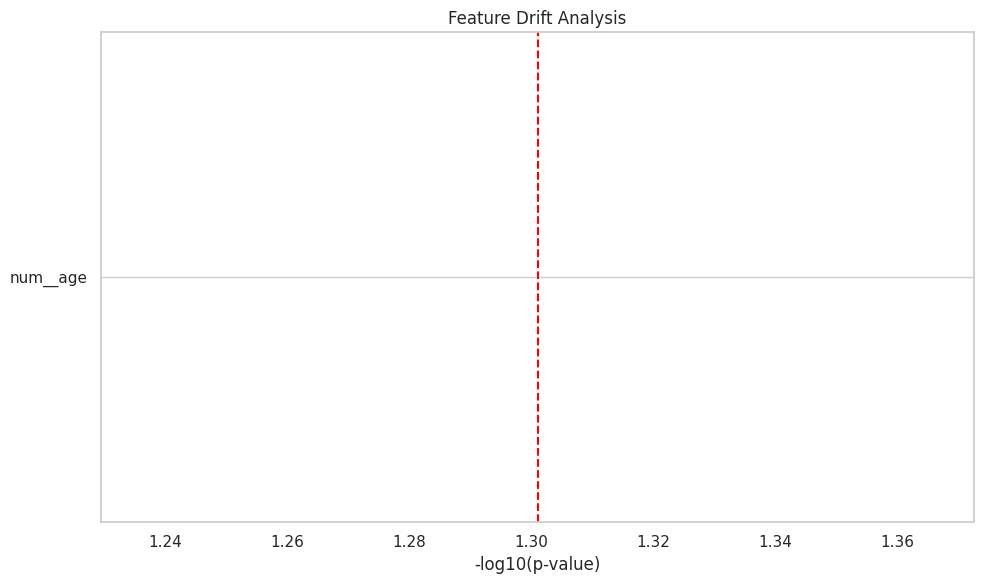

Overall drift detected: False
Number of drifted features: 0
Drifted features: []

=== Final Outputs ===
1. best_credit_risk_model.pkl - Tuned model
2. preprocessor.pkl - Data pipeline
3. drift_reference.pkl - Monitoring reference data
4. feature_names.json - Feature reference


In [29]:

# 11. Hyperparameter Tuning (Next Step)
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        scale_pos_weight=sum(y_train==0)/sum(y_train==1),
        random_state=42
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

# ======================
# 12. Alternative Models (Next Step)
# ======================
print("\n=== Alternative Models ===")
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Random Forest
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=200
)
rf.fit(X_train_res, y_train_res)

# LightGBM
lgbm = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=200
)
lgbm.fit(X_train_res, y_train_res)

# Compare performance
models = {
    'XGBoost': model,
    'Random Forest': rf,
    'LightGBM': lgbm
}

results = []
for name, clf in models.items():
    y_pred = clf.predict(X_test_processed)
    roc = roc_auc_score(y_test, clf.predict_proba(X_test_processed)[:, 1])
    results.append([name, roc])

results_df = pd.DataFrame(results, columns=['Model', 'ROC-AUC'])
print("\nModel Comparison:")
display(results_df.sort_values('ROC-AUC', ascending=False))

# ======================
# 13. Model Deployment Prep (Next Step)
# ======================
print("\n=== Deployment Preparation ===")
import json

# Save feature names
feature_names = preprocessor.get_feature_names_out().tolist()
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)

# Create prediction function
def predict_credit_risk(input_data):
    """Process input and return prediction"""
    input_df = pd.DataFrame([input_data])
    processed = preprocessor.transform(input_df)
    proba = best_model.predict_proba(processed)[0][1]
    return {
        'probability': float(proba),
        'risk_level': 'High' if proba > 0.5 else 'Low',
        'decision': 'Reject' if proba > 0.5 else 'Approve'
    }

# Test prediction
sample_input = {
    'age': 35,
    'ed': 5,
    'employ': 3,
    'address': 2,
    'income': 50000,
    'debtinc': 15.5,
    'creddebt': 2000,
    'othdebt': 3000
}
print("\nSample Prediction:", predict_credit_risk(sample_input))

# ======================
# 14. Drift Monitoring Setup (Next Step) - UPDATED
# ======================
print("\n=== Drift Monitoring ===")
from scipy.stats import ks_2samp
import numpy as np

def detect_drift(reference_data, current_data, feature_names, threshold=0.05):
    """
    Custom drift detection using Kolmogorov-Smirnov test
    Returns: (overall_drift, drift_report)
    """
    drift_results = {
        'is_drift': False,
        'drifted_features': [],
        'p_values': [],
        'statistics': []
    }

    for i, name in enumerate(feature_names):
        stat, p = ks_2samp(reference_data[:, i], current_data[:, i])
        drift_results['p_values'].append(p)
        drift_results['statistics'].append(stat)
        if p < threshold:
            drift_results['is_drift'] = True
            drift_results['drifted_features'].append(name)

    return drift_results

def plot_drift_results(drift_report, feature_names):
    """Visualize drift detection results"""
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, -np.log10(drift_report['p_values']))
    plt.axvline(-np.log10(0.05), color='red', linestyle='--')
    plt.xlabel('-log10(p-value)')
    plt.title('Feature Drift Analysis')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Convert to arrays if sparse
X_ref = X_train_res[:1000].toarray() if hasattr(X_train_res, 'toarray') else X_train_res[:1000]
X_curr = X_test_processed[:100].toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed[:100]

# Run drift detection
drift_report = detect_drift(X_ref, X_curr, feature_names)

# Visualize results
plot_drift_results(drift_report, feature_names)

# Print summary
print(f"Overall drift detected: {drift_report['is_drift']}")
print(f"Number of drifted features: {len(drift_report['drifted_features'])}")
print("Drifted features:", drift_report['drifted_features'])

# Save drift reference data for future monitoring
drift_reference = {
    'X_ref': X_ref,
    'feature_names': feature_names,
    'date': pd.Timestamp.now().strftime('%Y-%m-%d')
}

joblib.dump(drift_reference, 'drift_reference.pkl')

# ======================
# 15. Final Model Saving (Next Step) - UPDATED
# ======================
joblib.dump(best_model, 'best_credit_risk_model.pkl')

print("\n=== Final Outputs ===")
print("1. best_credit_risk_model.pkl - Tuned model")
print("2. preprocessor.pkl - Data pipeline")
print("3. drift_reference.pkl - Monitoring reference data")
print("4. feature_names.json - Feature reference")


In [30]:
def test_model_manually():
    """Interactive console testing"""
    print("Enter customer details for credit risk assessment:")

    # Get input features
    age = int(input("Age: "))
    education = int(input("Education (years): "))
    employment = int(input("Employment (years): "))
    address = int(input("Time at address (years): "))
    income = float(input("Annual income: "))
    debt_ratio = float(input("Debt-to-income ratio (%): ")) / 100
    credit_debt = float(input("Credit card debt: "))
    other_debt = float(input("Other debt: "))

    # Create input dictionary
    input_data = {
        'age': age,
        'ed': education,
        'employ': employment,
        'address': address,
        'income': income,
        'debtinc': debt_ratio * 100,  # Convert back to percentage
        'creddebt': credit_debt,
        'othdebt': other_debt
    }

    # Make prediction
    result = predict_credit_risk(input_data)

    print("\n=== Risk Assessment ===")
    print(f"Default Probability: {result['probability']:.1%}")
    print(f"Risk Level: {result['risk_level']}")
    print(f"Decision: {result['decision']}")

# Run the tester
test_model_manually()

Enter customer details for credit risk assessment:
Age: 45
Education (years): 2002
Employment (years): 12
Time at address (years): 67
Annual income: 7800
Debt-to-income ratio (%): 89
Credit card debt: 78
Other debt: 67

=== Risk Assessment ===
Default Probability: 73.3%
Risk Level: High
Decision: Reject
